In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Sat Aug 26 20:25:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   26C    P8    14W / 230W |  21594MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Hyperparams

In [3]:
n_mels = 1205
n_outputs = 61
n_frames = 400

In [4]:
from model.model_glowtts_sid import Model
from utils.util import *
from tensorboardX import SummaryWriter

step = 0
device = 'cuda:0'

# Model
model = Model(in_dim=n_mels, enc_hidden_dim=256, out_dim=61, dec_hidden_dim=256)
model = model.to(device)
model.eval()
print('done')

done


In [5]:
!ls -lt /data/scpark/save/lips/train08.21-1/

total 646944
-rw-rw-r-- 1 scpark scpark        40  8월 24 17:37 events.out.tfevents.1692866096.GPUSVR01
-rw-rw-r-- 1 scpark scpark        40  8월 24 17:34 events.out.tfevents.1692865738.GPUSVR01
-rw-rw-r-- 1 scpark scpark 662455517  8월 24 10:46 save_130000


In [6]:
path = '/data/scpark/save/lips/train08.21-1/save_130000'
checkpoint = torch.load(path, map_location=torch.device('cpu'))    
model.load_state_dict(checkpoint['model_state_dict'], strict=True)
print('done')

done


In [7]:
!ls -lS samples/

total 4416
-rw-rw-r-- 1 scpark scpark 678204  8월 26 20:23 infer08.24-1.npy
-rw-rw-r-- 1 scpark scpark 678204  8월 26 20:23 infer08.24-2.npy
-rw-rw-r-- 1 scpark scpark 678204  8월 26 20:23 infer08.24-3.npy
-rw-rw-r-- 1 scpark scpark 678204  8월 26 20:23 infer08.24-4.npy
-rw-rw-r-- 1 scpark scpark 678204  8월 26 20:23 infer08.24-5.npy
-rw-rw-r-- 1 scpark scpark 384572  8월 21 14:36 reg_dvae_flow.ipynb
-rw-rw-r-- 1 scpark scpark 275738  8월 26 20:03 comparison.ipynb
-rw-rw-r-- 1 scpark scpark 157264  8월 25 15:20 infer08.14-3.npy
-rw-rw-r-- 1 scpark scpark 157264  8월 25 15:02 infer08.21-1.npy
-rw-rw-r-- 1 scpark scpark 136236  8월 24 11:15 good.wav


In [8]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

processor = Wav2Vec2Processor.from_pretrained("kresnik/wav2vec2-large-xlsr-korean")
wav2vec = Wav2Vec2ForCTC.from_pretrained("kresnik/wav2vec2-large-xlsr-korean").to(device)
print('done')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


done


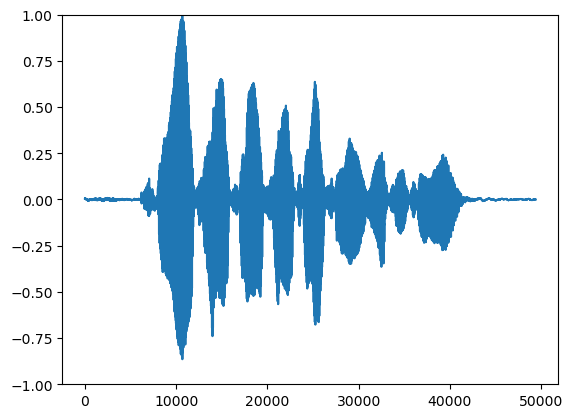

In [14]:
import matplotlib.pyplot as plt
#wav_file = '/Storage/speech/tts/kaist-audio-book/wav/남1_동화1/1181.wav'
#wav_file = '/Storage/speech/tts/kaist-audio-book/wav/여1_동화1/1181.wav'
wav_file = 'samples/good.wav'
wav, _ = librosa.load(wav_file, sr=16000, res_type='polyphase')
wav = wav / max(abs(wav))

plt.plot(wav)
plt.ylim([-1, 1])
plt.show()

In [15]:
def get_blendshape(wav, sid):
    # Get probs.
    with torch.no_grad():
        logits = wav2vec(torch.Tensor(wav).unsqueeze(0).to(device)).logits
        print(wav.shape, logits.shape)
        probs = torch.softmax(logits, dim=-1).transpose(1, 2)
        probs = F.interpolate(probs, scale_factor=3/5, mode='linear').detach()
    sid = torch.Tensor([sid]).long().to(device)
    with torch.no_grad():
        y = model.inference(probs, sid=sid, temperature=0.1)
        y = torch.clamp(y, min=0, max=1)
    y = y[0].data.cpu().numpy()
    return y
    
ys = []
for sid in range(1, 8):
    y = get_blendshape(wav, sid)
    ys.append(y)
    
ys = np.stack(ys)
print(ys.shape)

np.save('samples/infer08.21-1.npy', ys)
print('done')

(49413,) torch.Size([1, 154, 1205])
(49413,) torch.Size([1, 154, 1205])
(49413,) torch.Size([1, 154, 1205])
(49413,) torch.Size([1, 154, 1205])
(49413,) torch.Size([1, 154, 1205])
(49413,) torch.Size([1, 154, 1205])
(49413,) torch.Size([1, 154, 1205])
(7, 61, 92)
done


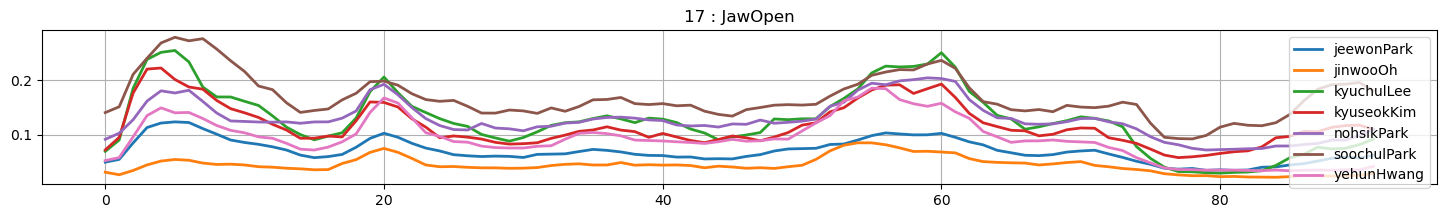

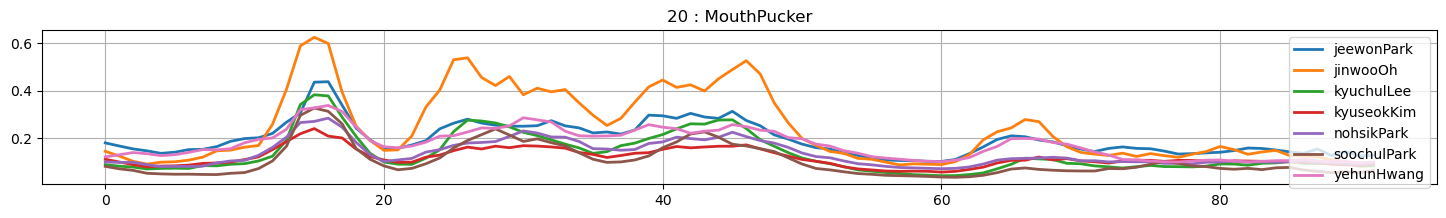

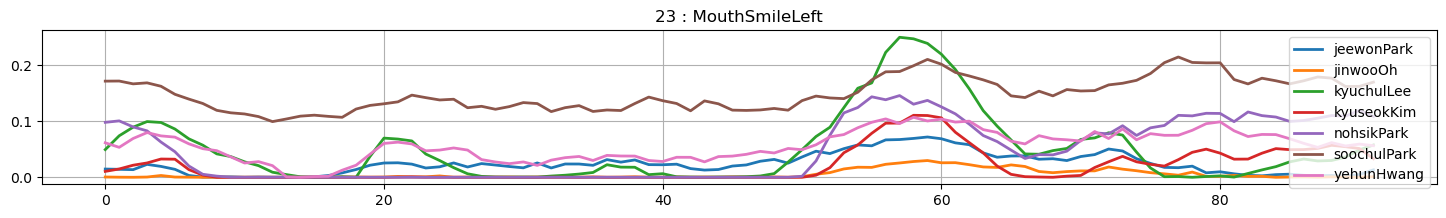

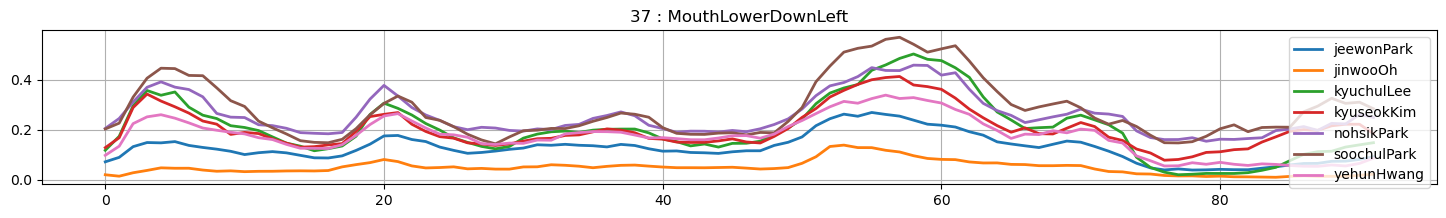

In [16]:
names = ['jeewonPark', 'jinwooOh', 'kyuchulLee', 'kyuseokKim', 'nohsikPark', 'soochulPark', 'yehunHwang']
targets = [(17, 'JawOpen'), (20, 'MouthPucker'), (23, 'MouthSmileLeft'), (37, 'MouthLowerDownLeft')]

for target in targets:
    plt.figure(figsize=[18, 2])
    plt.title(str(target[0]) + ' : ' + target[1])
    for i in range(len(ys)):
        plt.plot(ys[i][target[0]], label=names[i], linewidth=2)
    plt.grid()
    plt.legend()
    plt.show()